### Loading and examining data

Tuesday July 2nd. Second version, creating a SelfTrainingRegressor class to test out different models (in addition to XGBoost). Need to add hyperparameter tuning.

In [2]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

from xgboost import XGBRegressor

# more models
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



In [3]:
df = pd.read_csv('merged_data_sub_10.csv')
df.shape # before cleaning

(4262, 58)

In [4]:
thresh = len(df) * 0.05 # drop column if missing values in more than 95% of rows
df = df.dropna(thresh=thresh, axis = 1)
thresh2 = 20 # drop rows with < 20 non-missing
df = df.dropna(thresh=thresh2, axis=0)

In [5]:
df.shape # after cleaning

(4262, 58)

In [6]:
print(df.columns)

Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'SDMVPSU',
       'SDMVSTRA', 'WTMEC4YR', 'SDDSRVYR', 'RIDSTATR', 'LBXSAL', 'LBDSALSI',
       'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI', 'LBXSCA',
       'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL',
       'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH', 'LBDSPHSI',
       'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR', 'LBDSTRSI',
       'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI', 'LBXSCLSI',
       'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI', 'LBXLH',
       'LBDLHSI', 'SSCYPC', 'WTSCY4YR', 'LBXSCR', 'eGFR', 'eGFR_no_race',
       'change_in_eGFR', 'eGFRcys', 'change_in_eGFR_cys', 'simulated_mGFR'],
      dtype='object')


In [7]:
# Further preparing the data 
# Drop irrelevant columns
columns_to_drop = ["SDMVPSU", "SDMVSTRA", "WTMEC4YR", "SDDSRVYR", "RIDSTATR", "WTSCY4YR"]
df = df.drop(columns=columns_to_drop)
# Encode categorical variables
label_encoders = {}
for column in ["RIAGENDR", "RIDRETH2", "RIDEXPRG"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le
    
# separating and printing shapes
labeled_data = df[df['simulated_mGFR'].notna()]
unlabeled_data = df[df['simulated_mGFR'].isna()]

X_labeled = labeled_data.drop(columns=['simulated_mGFR'])
y_labeled = labeled_data['simulated_mGFR']
X_unlabeled = unlabeled_data.drop(columns=['simulated_mGFR'])

print(X_labeled.shape, y_labeled.shape, X_unlabeled.shape)

(426, 51) (426,) (3836, 51)


### XGBoost using ONLY labeled data (426 samples in total for training and testing)

In [8]:
# y_labeled = y_labeled.to_numpy()
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

In [9]:
# Count the number of rows in X_train that contain NaN values
num_cols_with_nan = X_train_labeled.isnull().any(axis=0).sum()
cols_with_nan_train = X_train_labeled.columns[X_train_labeled.isnull().any(axis=0)]
cols_with_nan_unlabeled = X_unlabeled.columns[X_unlabeled.isnull().any(axis=0)]
num_rows_with_nan = X_train_labeled.isnull().any(axis=1).sum()

print(f"Number of cols with NaN values in X_train_labeled: {num_cols_with_nan}")
print("X_train cols with NaN: ", cols_with_nan_train)
print("X_unlabeled cols with NaN: ", cols_with_nan_unlabeled)

my_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

# Fit and transform X_train_labeled
X_train_labeled = my_pipeline.fit_transform(X_train_labeled)
X_train_labeled = pd.DataFrame(X_train_labeled)

# Transform X_test_labeled and X_unlabeled
X_test_labeled = my_pipeline.transform(X_test_labeled)
X_test_labeled = pd.DataFrame(X_test_labeled)
X_unlabeled = my_pipeline.transform(X_unlabeled)
X_unlabeled = pd.DataFrame(X_unlabeled)


# ALTERNATIVELY, drop columns with NaN values, but make sure dropping the same ones
# X_train_labeled = X_train_labeled.dropna(axis=1)
# X_unlabeled = X_unlabeled.dropna(axis = 1)
# X_test_labeled = X_test_labeled.dropna(axis=1)



Number of cols with NaN values in X_train_labeled: 6
X_train cols with NaN:  Index(['LBXSGL', 'LBDSGLSI', 'LBXFSH', 'LBDFSHSI', 'LBXLH', 'LBDLHSI'], dtype='object')
X_unlabeled cols with NaN:  Index(['LBXSLDSI', 'LBXSTP', 'LBDSTPSI', 'LBXSCLSI', 'LBXSGB', 'LBDSGBSI',
       'LBXFSH', 'LBDFSHSI', 'LBXLH', 'LBDLHSI'],
      dtype='object')


In [12]:
model_factory = [
    RandomForestRegressor(),
    XGBRegressor(nthread=1),
    # MLPRegressor(),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(),
    ElasticNet(),
    # KNeighborsRegressor(),
    GradientBoostingRegressor()
]

for model in model_factory:
    model.seed = 42
    model.fit(X_train_labeled, y_train_labeled)

    y_pred = model.predict(X_test_labeled)
    # Evaluate the model
    r2 = r2_score(y_test_labeled, y_pred)
    mae = mean_absolute_error(y_test_labeled, y_pred)

    # num_folds = 5

    # scores = cross_val_score(model, X_train_labeled, y_train_labeled, cv=num_folds, scoring='r2', n_jobs=8)
    # mae =  cross_val_score(model, X_train_labeled, y_train_labeled, cv=num_folds, scoring='neg_mean_absolute_error', n_jobs=8)
    r2 = " %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2) 
    mae = " %0.2f (+/- %0.2f)" % (mae.mean(), mae.std() * 2) 

    print('{model:25} CV-5 R2: {r2} MAE {mae}'.format(
        model=model.__class__.__name__,
        r2=r2,
        mae=mae
    ))

RandomForestRegressor     CV-5 R2:  0.66 (+/- 0.00) MAE  12.27 (+/- 0.00)
XGBRegressor              CV-5 R2:  0.67 (+/- 0.00) MAE  12.73 (+/- 0.00)
Ridge                     CV-5 R2:  0.68 (+/- 0.00) MAE  12.08 (+/- 0.00)
BayesianRidge             CV-5 R2:  0.67 (+/- 0.00) MAE  12.39 (+/- 0.00)
ExtraTreesRegressor       CV-5 R2:  0.66 (+/- 0.00) MAE  12.49 (+/- 0.00)
ElasticNet                CV-5 R2:  0.64 (+/- 0.00) MAE  13.22 (+/- 0.00)
GradientBoostingRegressor CV-5 R2:  0.65 (+/- 0.00) MAE  12.78 (+/- 0.00)


In [13]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.utils import resample
import numpy as np
import pandas as pd

class SelfTrainingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_regressor, X_unlabeled, feature_names, y_test_labeled, threshold, max_iter=10):
        self.base_regressor = base_regressor
        self.X_unlabeled = X_unlabeled
        self.feature_names = feature_names
        self.y_test_labeled = y_test_labeled
        self.threshold = threshold
        self.max_iter = max_iter

    def fit(self, X_labeled, y_labeled):
        self.model = clone(self.base_regressor)
        for iteration in range(self.max_iter):
            self.model.fit(X_labeled, y_labeled)
            y_unlabeled_pred = self.model.predict(self.X_unlabeled)
            
            bootstrapped_predictions = []
            for _ in range(10):
                X_boot, y_boot = resample(X_labeled, y_labeled)
                self.model.fit(X_boot, y_boot)
                bootstrapped_predictions.append(self.model.predict(self.X_unlabeled))
            
            uncertainty = np.std(bootstrapped_predictions, axis=0)
            confident_indices = np.where(uncertainty <= self.threshold)[0]
            
            if len(confident_indices) == 0:
                print(f"No confident predictions found below uncertainty threshold {self.threshold}. Stopping iterations.")
                break
            
            X_labeled = pd.concat([X_labeled, self.X_unlabeled.iloc[confident_indices]], ignore_index=True)
            y_labeled = np.concatenate([y_labeled, y_unlabeled_pred[confident_indices]])
            self.X_unlabeled = self.X_unlabeled.drop(self.X_unlabeled.index[confident_indices]).reset_index(drop=True)
            
            print(f'Iteration {iteration+1}: Added {len(confident_indices)} confident predictions to the labeled dataset.')
        
        print(f"Final labeled dataset size: {len(y_labeled)}")
        return self

    def predict(self, X):
        return self.model.predict(X)

In [14]:
model_factory = [
    SelfTrainingRegressor(
        base_regressor=RandomForestRegressor(),
        X_unlabeled=X_unlabeled,
        feature_names=list(X_train_labeled.columns),
        y_test_labeled=y_test_labeled,
        threshold = 6
    ),
    SelfTrainingRegressor(
        base_regressor=XGBRegressor(nthread=1),
        X_unlabeled=X_unlabeled,
        feature_names=list(X_train_labeled.columns),
        y_test_labeled=y_test_labeled,
        threshold = 6
    )
    # # MLPRegressor(), this errors 
    # Ridge(),
    # BayesianRidge(),
    # ExtraTreesRegressor(),
    # ElasticNet(),
    # # KNeighborsRegressor(),
    # GradientBoostingRegressor()
]

for model in model_factory:
    model.seed = 42

    model.fit(X_train_labeled, y_train_labeled)
    y_pred = model.predict(X_test_labeled)
    # Evaluate the model
    r2 = r2_score(y_test_labeled, y_pred)
    mae = mean_absolute_error(y_test_labeled, y_pred)

    # num_folds = 5

    # scores = cross_val_score(model, X_train_labeled, y_train_labeled, cv=num_folds, scoring='r2', n_jobs=8)
    # mae =  cross_val_score(model, X_train_labeled, y_train_labeled, cv=num_folds, scoring='neg_mean_absolute_error', n_jobs=8)
    r2 = " %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2) 
    mae = " %0.2f (+/- %0.2f)" % (mae.mean(), mae.std() * 2) 

    print('{model:25} CV-5 R2: {r2} MAE {mae}'.format(
        model=model.__class__.__name__,
        r2=r2,
        mae=mae
    ))

Iteration 1: Added 3059 confident predictions to the labeled dataset.
Iteration 2: Added 689 confident predictions to the labeled dataset.
Iteration 3: Added 47 confident predictions to the labeled dataset.
Iteration 4: Added 9 confident predictions to the labeled dataset.
Iteration 5: Added 11 confident predictions to the labeled dataset.
Iteration 6: Added 3 confident predictions to the labeled dataset.
Iteration 7: Added 2 confident predictions to the labeled dataset.
Iteration 8: Added 2 confident predictions to the labeled dataset.
Iteration 9: Added 2 confident predictions to the labeled dataset.
Iteration 10: Added 1 confident predictions to the labeled dataset.
Final labeled dataset size: 4165
SelfTrainingRegressor     CV-5 R2:  0.65 (+/- 0.00) MAE  12.62 (+/- 0.00)
Iteration 1: Added 1144 confident predictions to the labeled dataset.
Iteration 2: Added 2028 confident predictions to the labeled dataset.
Iteration 3: Added 508 confident predictions to the labeled dataset.
Iterat

In [8]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [25, 50, 100, 200, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# XGBoost, grid search and 5 fold CV
xgb_regressor = XGBRegressor()
grid_search = RandomizedSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb_regressor = grid_search.best_estimator_

In [9]:
# Evaluate on the validation set
y_val_pred = best_xgb_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_val_pred)
print(f'Mean Squared Error on validation set: {mse}')

Mean Squared Error on validation set: 225.1862931971374


In [10]:
start_time = time.time()
best_xgb_regressor.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5539340972900391 seconds ---


In [11]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("stdv:", scores.std())

from sklearn.model_selection import cross_val_score
start_time = time.time()
score = cross_val_score(best_xgb_regressor, X_train, y_train,
                         scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
xbg_mae_scores = -score
display_scores(xbg_mae_scores)
print("--- %s seconds ---" % (time.time() - start_time))

Scores: [12.71915891 12.23706262 12.76720378 11.76761097 12.51092806]
Mean: 12.400392866699637
stdv: 0.36755129092418637
--- 1.1803178787231445 seconds ---


In [14]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, best_xgb_regressor.predict(X_test))

12.008682204685666

In [15]:
from sklearn.metrics import r2_score
r2_score(y_test, best_xgb_regressor.predict(X_test))

0.6747487909151992

Text(0, 0.5, 'Count')

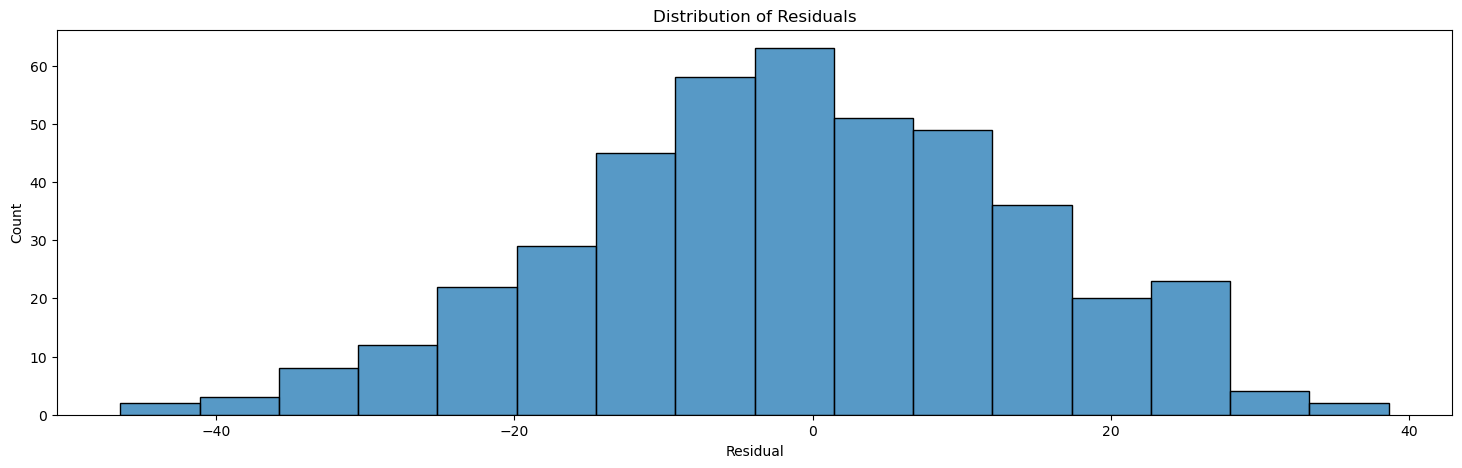

In [16]:
xbg_preds = best_xgb_regressor.predict(X_test)
actuals = y_test
resids = xbg_preds - actuals
plt.figure(figsize=(18,5))
sns.histplot(resids);
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')

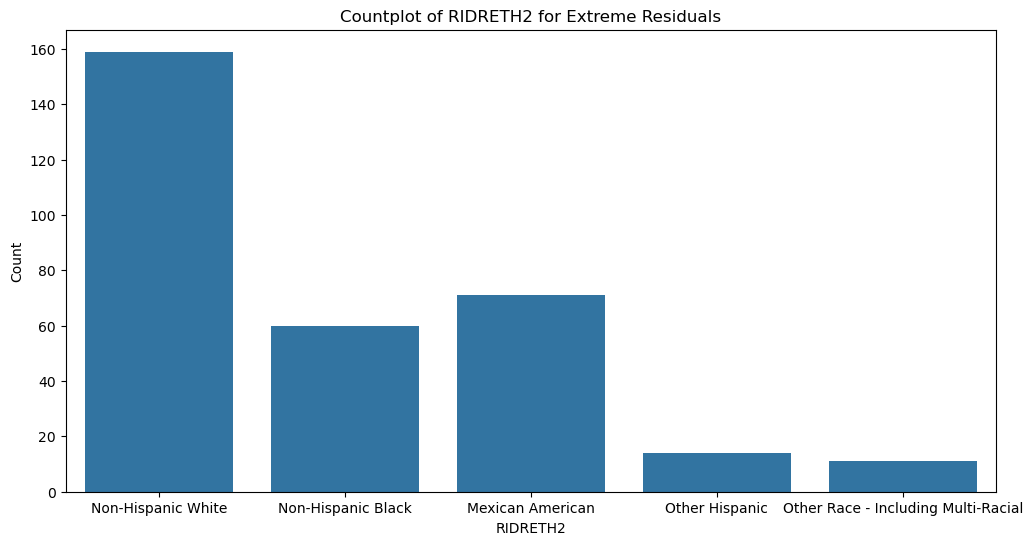

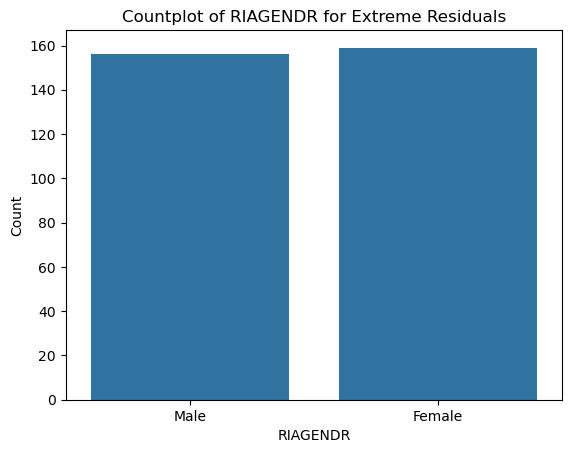

In [17]:
# turn y_test into Pandas series so can index
y_test_series = pd.Series(y_test, index=df.index[:len(y_test)])

# Convert residuals to a pandas Series with the same index
resids_series = pd.Series(resids, index=y_test_series.index)

# Filter the indices where residuals are less than -5 or greater than 5 
filtered_indices = resids_series[(resids_series < -5) | (resids_series > 5)].index
df['RIDRETH2_decoded'] = label_encoders['RIDRETH2'].inverse_transform(df['RIDRETH2'])
df['RIAGENDR_decoded'] = label_encoders['RIAGENDR'].inverse_transform(df['RIAGENDR'])
plt.figure(figsize=(12, 6))
sns.countplot(data=df.loc[filtered_indices], x='RIDRETH2_decoded')
plt.title('Countplot of RIDRETH2 for Extreme Residuals')
plt.xlabel('RIDRETH2')
plt.ylabel('Count')
plt.show()

sns.countplot(data=df.loc[filtered_indices], x='RIAGENDR_decoded')
plt.title('Countplot of RIAGENDR for Extreme Residuals')
plt.xlabel('RIAGENDR')
plt.ylabel('Count')
plt.show()


/var/folders/6p/6161x96942x8rv20mn8nby2r0000gn/T/ipykernel_2834/3522221576.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

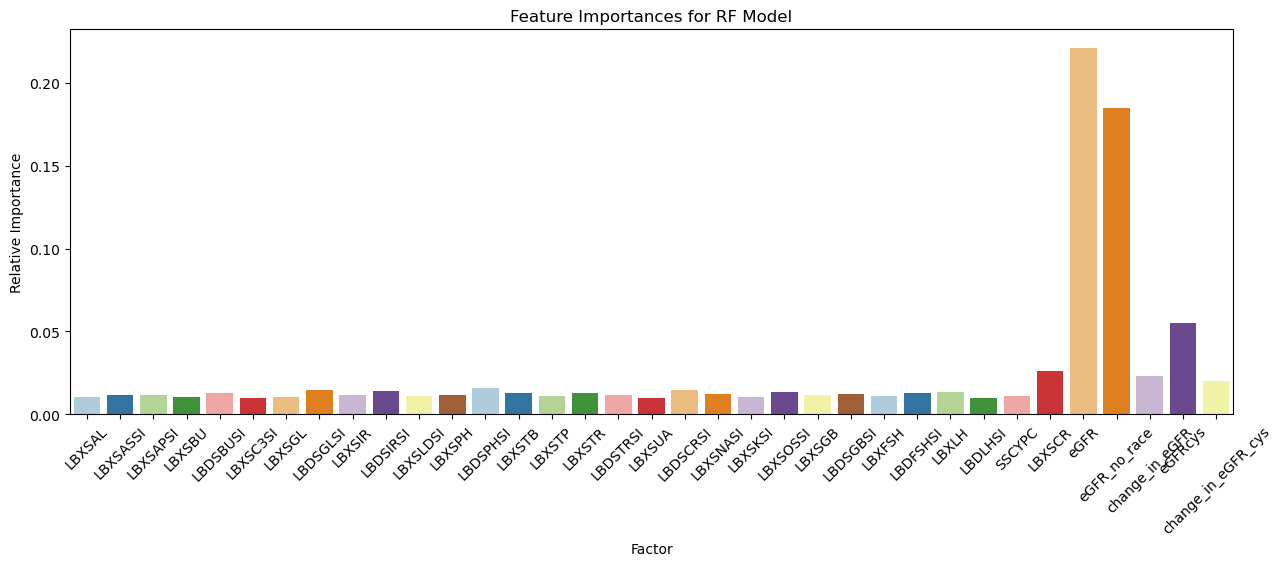

In [18]:
varimp = []
for name, score in zip(X_labeled.columns, best_xgb_regressor.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');
plt.xticks(rotation=45)

In [19]:
varimps.sort_values(by = 'Relative Importance', ascending=False)


,Factor,Relative Importance
30,eGFR,0.221095
31,eGFR_no_race,0.185004
33,eGFRcys,0.055304
29,LBXSCR,0.026191
32,change_in_eGFR,0.023249
34,change_in_eGFR_cys,0.019934
12,LBDSPHSI,0.015947
7,LBDSGLSI,0.014916
18,LBDSCRSI,0.014759
9,LBDSIRSI,0.013806


Text(0, 0.5, 'Actual Values')

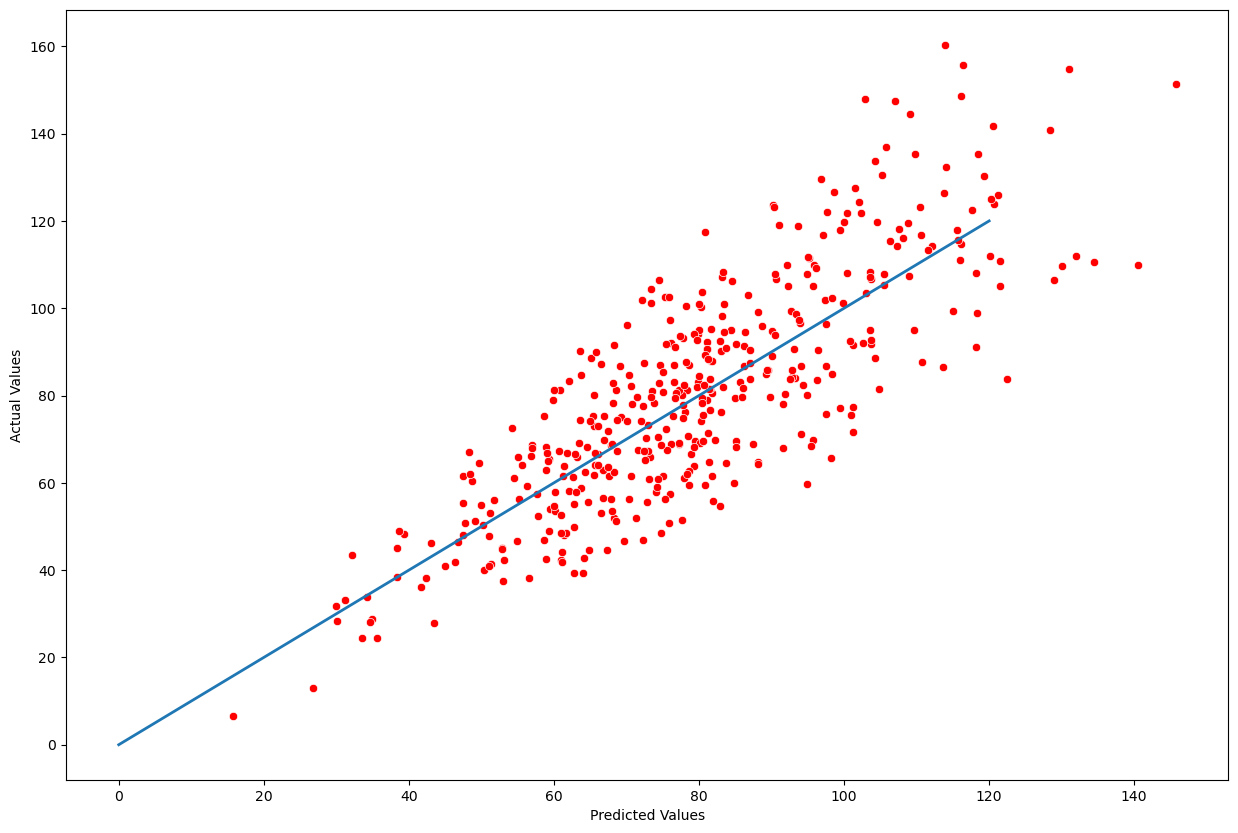

In [21]:
plt.figure(figsize=(15, 10));
sns.scatterplot(x=best_xgb_regressor.predict(X_test), y=y_test, color="red");
plt.plot([0, 120], [0, 120], linewidth=2);
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")